Here we draw figures for postprocessed pull-downs, particularly the bulk grid figures.

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('talk')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import parameters

import importlib
importlib.reload(parameters)

<module 'parameters' from '/notebooks/scatterplots/parameters.py'>

In [3]:
POINT_COLOR = parameters.COLOUR_BACKGROUND

In [4]:
from snapanalysis.config import OUTPUT_DIRECTORY as OUTPUT_DIRECTORY_MAIN

OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY_MAIN, 'scatterplots')
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

OUTPUT_GRID_11 = os.path.join(OUTPUT_DIRECTORY, 'grid-11-postprocessed.pdf')
OUTPUT_GRID_11_NO_TITLES = os.path.join(OUTPUT_DIRECTORY, 'grid-11-postprocessed-no-titles.pdf')

In [5]:
from snapanalysis.models.enrichment.generate import OUTPUT_FILE as ENRICHMENT_FILE
from snapanalysis.models.enrichment.settings import ADJUSTED_IMPUTED_RATIO_FORWARD_COLUMN, ADJUSTED_IMPUTED_RATIO_REVERSE_COLUMN

In [6]:
def zero_lines(ax=None, color='k', linewidth=.5, zorder=1, **kwargs):

    ax.axhline(0, color=color, linewidth=linewidth, zorder=zorder, **kwargs)
    ax.axvline(0, color=color, linewidth=linewidth, zorder=zorder, **kwargs)

In [7]:
from matplotlib.font_manager import FontProperties

TITLE_FONT = FontProperties()
TITLE_FONT.set_family('Helvetica')
TITLE_FONT.set_weight('bold')
TITLE_FONT.set_size(22)

def plot_title(pull_down_ids, ax=None, color=None):
    if ax is None:
        ax = plt.gca()
        
    pull_down_ids = np.unique(pull_down_ids)
    assert len(pull_down_ids) == 1
    
    
    pull_down_id = pull_down_ids[0]

    ax.text(0.05, 0.95, pull_down_id,
            color='black',
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontproperties=TITLE_FONT)

In [8]:
with pd.HDFStore(ENRICHMENT_FILE, 'r') as store:
    print('\n'.join(store.keys()))
    
    enrichment_data = store['/enrichment_data']

/angles
/enrichment_data
/enrichment_matrix
/imputation_matrix
/settings


In [9]:
# Have short names for columns, otherwise matplotlib gets confused
df = enrichment_data[[ADJUSTED_IMPUTED_RATIO_FORWARD_COLUMN, ADJUSTED_IMPUTED_RATIO_REVERSE_COLUMN]].reset_index()
df = df.rename(columns={'Gene label': 'gl',
                        'Pull-Down ID': 'pd',
                        ADJUSTED_IMPUTED_RATIO_FORWARD_COLUMN: 'F',
                        ADJUSTED_IMPUTED_RATIO_REVERSE_COLUMN: 'R'})
HIGHLIGHTS = pd.Series(parameters.HIGHLIGHTS, name='color')
df = df.join(HIGHLIGHTS, on='gl')

df.head()

,gl,pd,F,R,color
0,A0A087X222,H01,-0.108824,0.093958,NaN
1,A0A087X222,H01M,0.000000,0.000000,NaN
2,A0A087X222,H02,0.187571,0.120295,NaN
3,A0A087X222,H03,-0.097007,-0.260904,NaN
4,A0A087X222,H03M,0.000000,0.000000,NaN


In [10]:
from snapanalysis.visualisation.heatmaps.pattern_heatmap import PULLDOWN_ORDER
order = PULLDOWN_ORDER

In [11]:
max_ = enrichment_data[[ADJUSTED_IMPUTED_RATIO_FORWARD_COLUMN, ADJUSTED_IMPUTED_RATIO_REVERSE_COLUMN]].abs().max().max()

In [12]:
limit = parameters.LIMITS_INTEGER * 1.1

# Grid 11 columns wide

In [13]:
import matplotlib.ticker as ticker

In [14]:
def plot_scatter(x, y, data, ax=None, size_other=20, size_highlight=150, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    others = data[data['color'].isnull()]
    highlights = data[~data['color'].isnull()]
    
    kwargs.pop('color', '')
    ax.scatter(others[x], others[y], color=POINT_COLOR, s=size_other, rasterized=True, **kwargs)
    
    for color, subdf in highlights.groupby('color'):
        ax.scatter(subdf[x], subdf[y], 
                   color=color, s=size_highlight,
                   linewidth=1.0, edgecolor='black',
                   **kwargs)
    

CPU times: user 33.4 s, sys: 19.1 s, total: 52.5 s
Wall time: 19.8 s


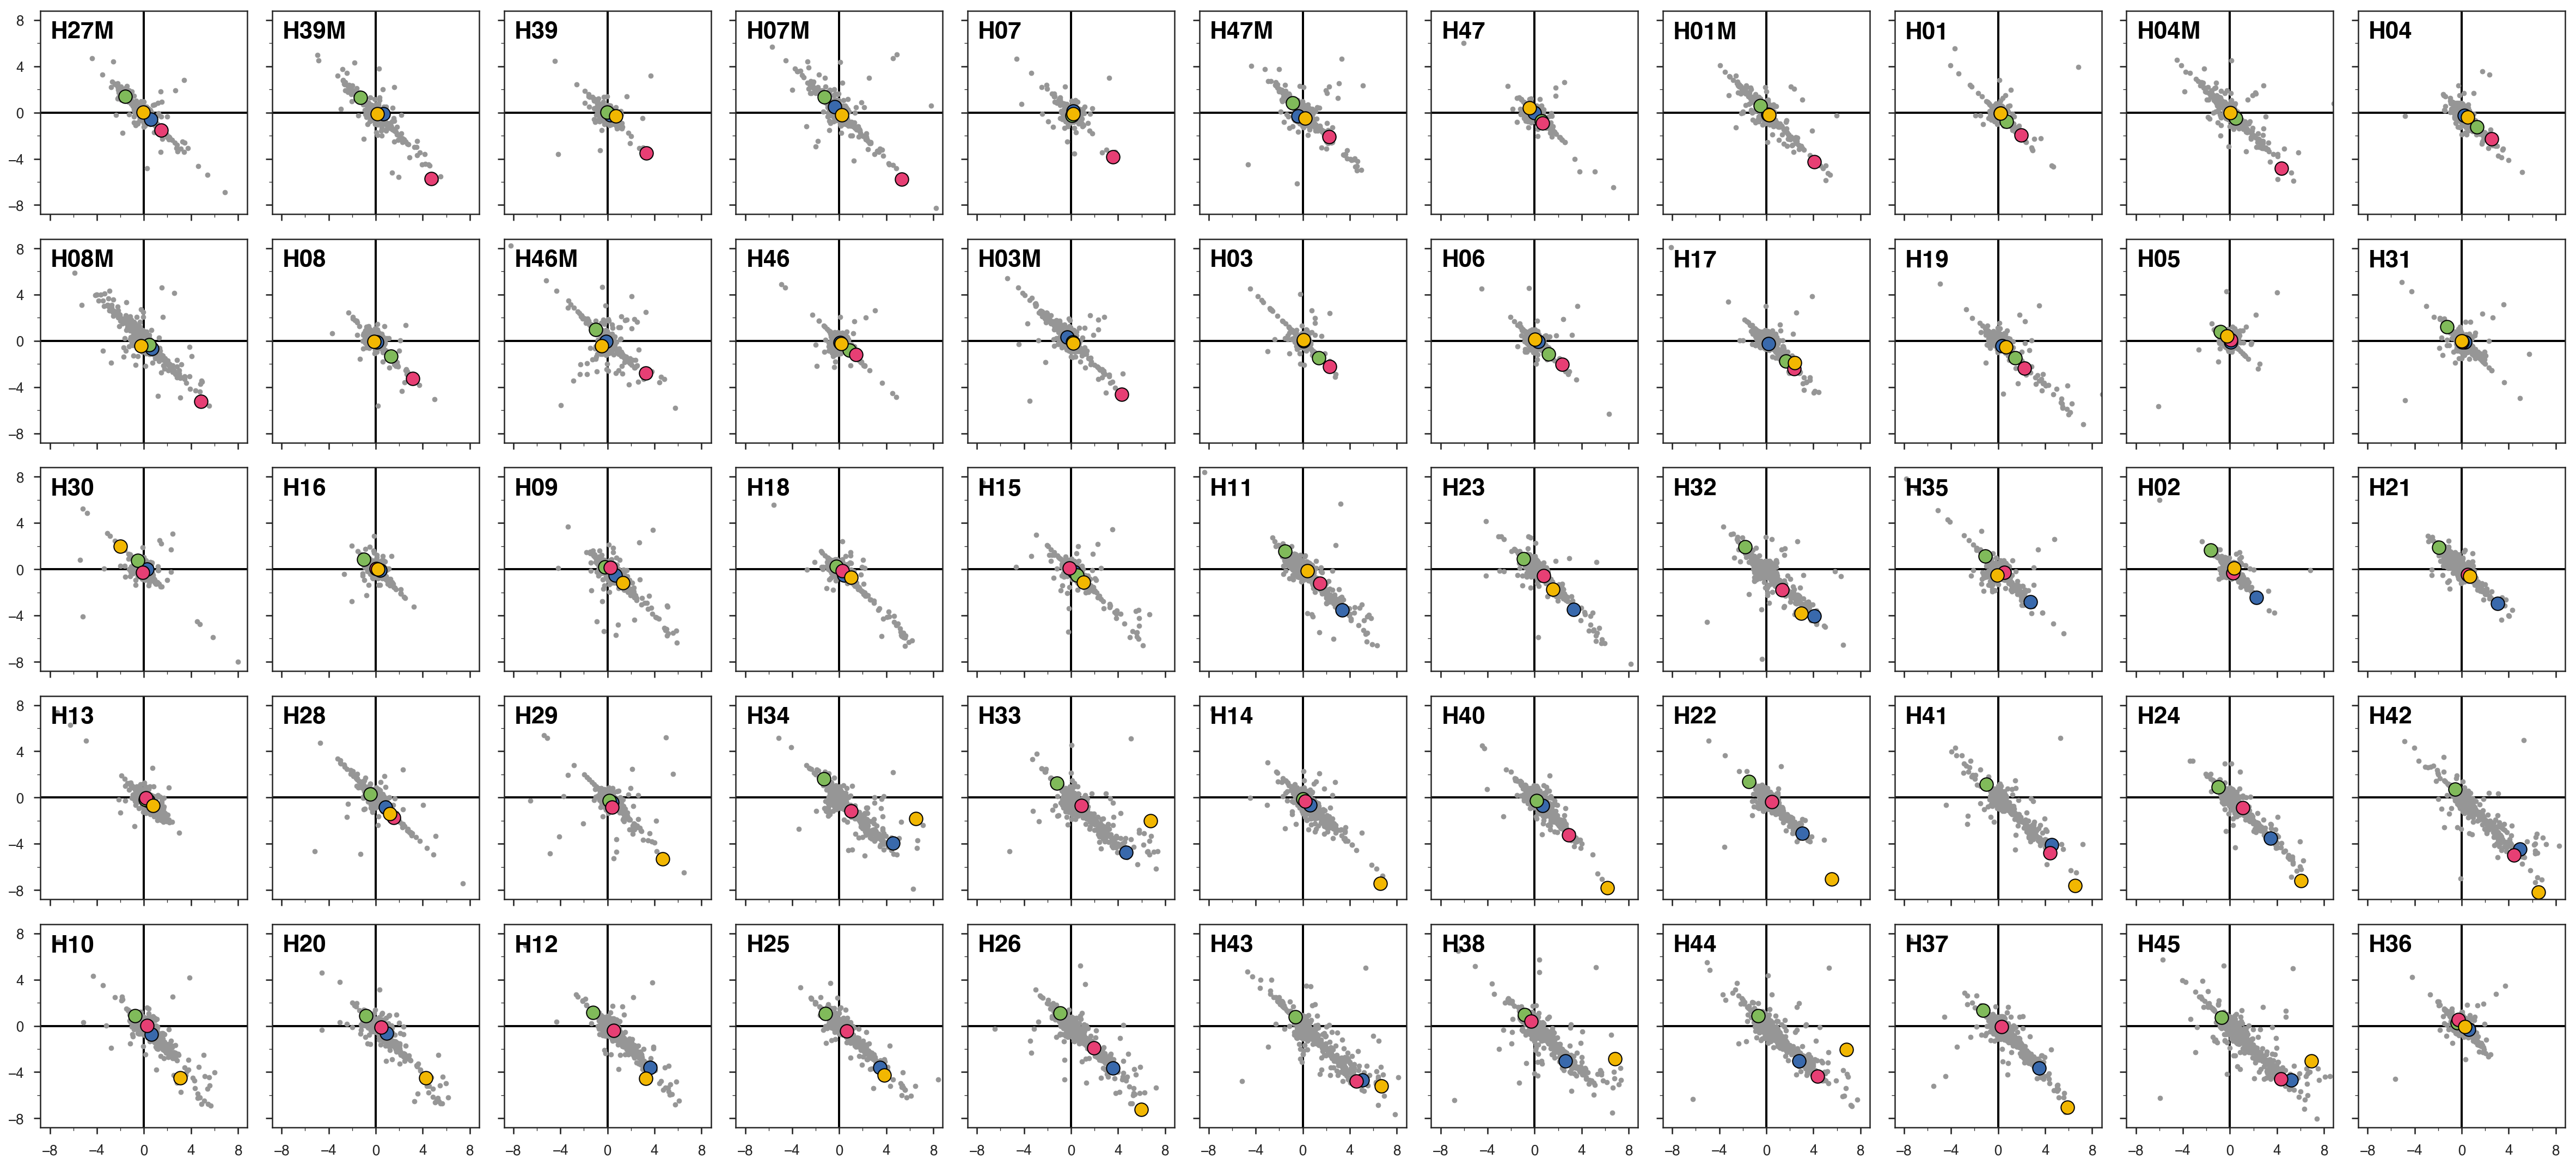

In [15]:
%%time 

fgrid = sns.FacetGrid(col='pd', 
                      col_wrap=11, 
                      col_order=order,
                      data=df,
                      dropna=False)


fgrid.map_dataframe(plot_scatter, 'F', 'R', zorder=2)

fgrid.map(plot_title, 'pd')

# fgrid.set_xlabels('Ratio H/L, forward')
# fgrid.set_ylabels('Ratio H/L, reverse')
fgrid.set_titles('')
fgrid.set_xlabels('')
fgrid.set_ylabels('')


for i, ax in enumerate(fgrid.axes):
    for side in ['top', 'right', 'left', 'bottom']:
        ax.spines[side].set_visible(True)
    ax.grid(False)
    zero_lines(ax=ax, linewidth=2)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.title.set_visible(False)
    
plt.tight_layout()
fgrid.savefig(OUTPUT_GRID_11)
    

CPU times: user 30.9 s, sys: 16.9 s, total: 47.9 s
Wall time: 18.1 s


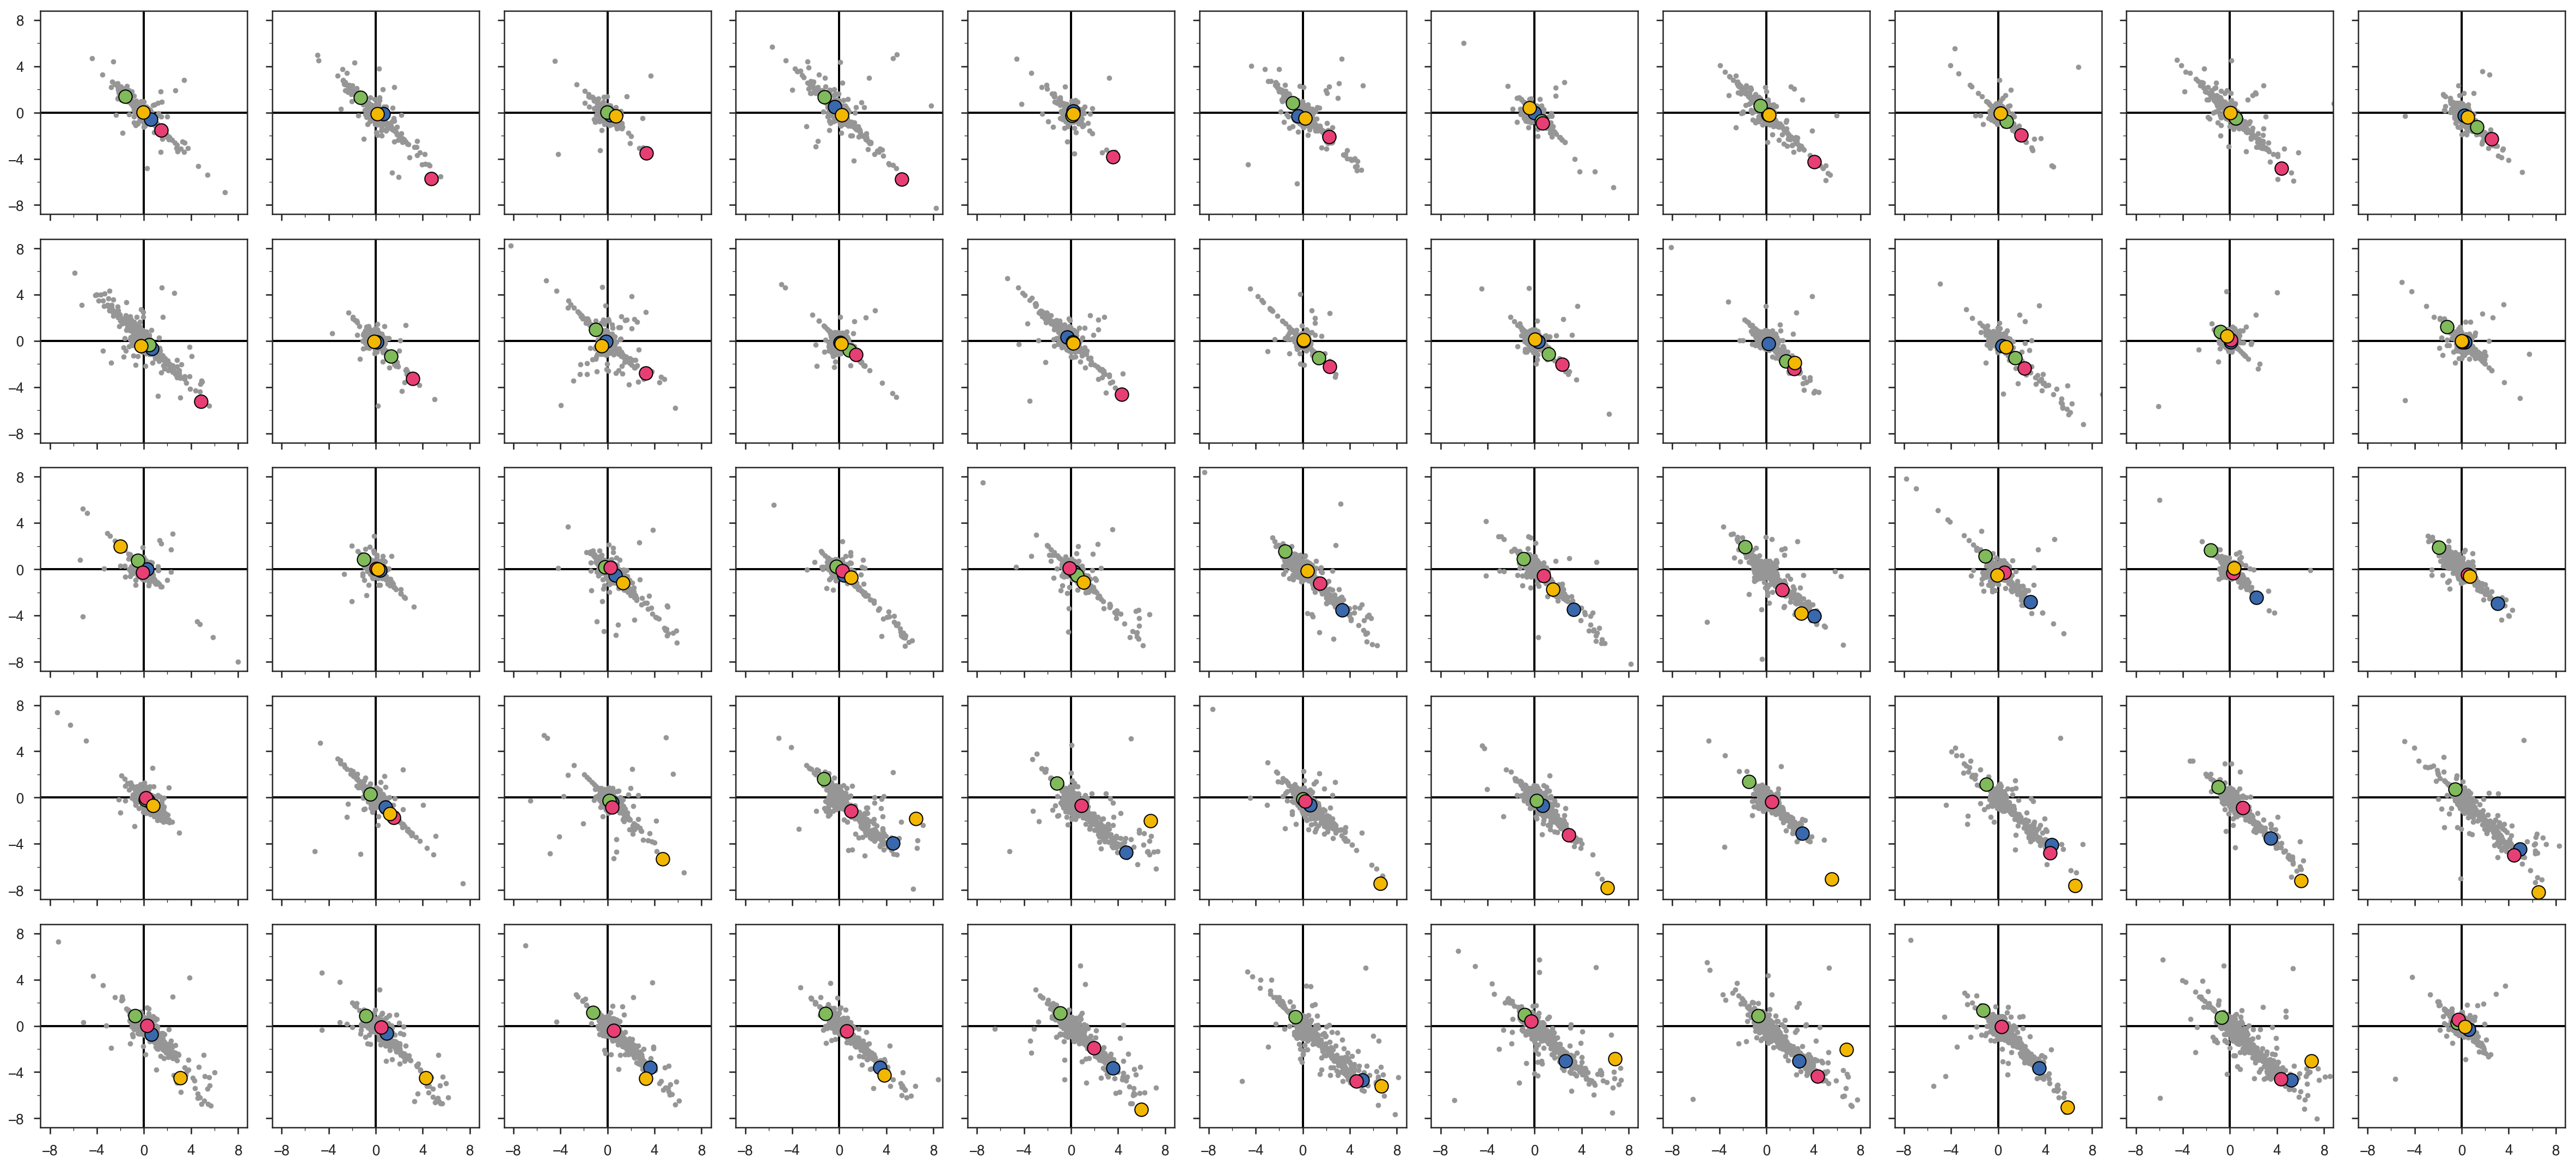

In [16]:
%%time 

fgrid = sns.FacetGrid(col='pd', 
                      col_wrap=11, 
                      col_order=order,
                      data=df,
                      dropna=False)


fgrid.map_dataframe(plot_scatter, 'F', 'R', zorder=2)

# fgrid.map(plot_title, 'pd')

# fgrid.set_xlabels('Ratio H/L, forward')
# fgrid.set_ylabels('Ratio H/L, reverse')
fgrid.set_titles('')
fgrid.set_xlabels('')
fgrid.set_ylabels('')


for i, ax in enumerate(fgrid.axes):
    for side in ['top', 'right', 'left', 'bottom']:
        ax.spines[side].set_visible(True)
    ax.grid(False)
    zero_lines(ax=ax, linewidth=2)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(parameters.MAJOR_TICKS))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(parameters.MINOR_TICKS))
    ax.title.set_visible(False)
    
plt.tight_layout()
fgrid.savefig(OUTPUT_GRID_11_NO_TITLES)
    